## Imports

In [ ]:
#%pip install -U "monai-weekly[tqdm]" matplotlib
#%matplotlib inline

In [ ]:
import os
import time
import tempfile
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import gudhi as gd
from gudhi.representations import PersistenceImage
from gudhi.wasserstein import wasserstein_distance
import cripser as cr
from __future__ import print_function, division
import torch
import torch.nn as nn
import torch.nn.functional as F
from monai import transforms
from monai.apps import DecathlonDataset
from monai.config import print_config
from monai.data import DataLoader
from monai.utils import first, set_determinism
from torch.amp import GradScaler, autocast
from tqdm import tqdm
from monai.inferers import ControlNetDiffusionInferer, DiffusionInferer
from monai.networks.nets import DiffusionModelUNet, ControlNet
from monai.networks.schedulers import DDPMScheduler

print_config()

## Data download, dataset splitting

In [ ]:
root_dir = "/home/pacificrim/topo-seg/monai_data"
os.makedirs(root_dir, exist_ok=True)

# !!!! if you want to download the dataset into a temporary directory, comment out the above lines and uncomment the next line
# root_dir = tempfile.mkdtemp()

In [5]:
set_determinism(42)

In [6]:
channel = 0
assert channel in [0, 1, 2, 3], "Choose a valid channel"

train_transforms = transforms.Compose(
    [
        transforms.LoadImaged(keys=["image","label"]),
        transforms.EnsureChannelFirstd(keys=["image","label"]),
        transforms.Lambdad(keys=["image"], func=lambda x: x[channel, :, :, :]),
        transforms.EnsureChannelFirstd(keys=["image"], channel_dim="no_channel"),
        transforms.EnsureTyped(keys=["image","label"]),
        # transforms.Orientationd(keys=["image"], axcodes="RAS"),
        transforms.Spacingd(keys=["image","label"], pixdim=(3.0, 3.0, 2.0), mode="bilinear"),
        transforms.CenterSpatialCropd(keys=["image","label"], roi_size=(64, 64, 44)),
        transforms.ScaleIntensityRangePercentilesd(keys="image", lower=0, upper=99.5, b_min=0, b_max=1),
        transforms.RandSpatialCropd(keys=["image","label"], roi_size=(64, 64, 1), random_size=False),
        transforms.Lambdad(keys=["image","label"], func=lambda x: x.squeeze(-1)),
    ]
)

In [ ]:
# Check if BraTS files exist
brats_data_dir = os.path.join(root_dir, "Task01_BrainTumour")
required_files = [
    "dataset.json",
    "imagesTr",  # Training images directory
    "labelsTr"   # Training labels directory
]

# Check if all required files exist
data_exists = all(
    os.path.exists(os.path.join(brats_data_dir, f)) 
    for f in required_files
)

if not data_exists:
    print("Downloading dataset")
    train_ds = DecathlonDataset(
        root_dir=root_dir,
        task="Task01_BrainTumour",
        section="training",
        cache_rate=1.0,
        num_workers=4,
        download=True, # true to download the dataset
        seed=0,
        transform=train_transforms,
    )
    
    val_ds = DecathlonDataset(
        root_dir=root_dir,
        task="Task01_BrainTumour",
        section="validation",
        cache_rate=1.0,
        num_workers=4,
        download=True,
        seed=0,
        transform=train_transforms,
    )
else:
    print("Dataset already downloaded")
    train_ds = DecathlonDataset(
        root_dir=root_dir,
        task="Task01_BrainTumour",
        section="training",
        cache_rate=1.0,
        num_workers=4,
        download=False,
        seed=0,
        transform=train_transforms,
    )
    
    val_ds = DecathlonDataset(
        root_dir=root_dir,
        task="Task01_BrainTumour",
        section="validation",
        cache_rate=1.0,
        num_workers=4,
        download=False,
        seed=0,
        transform=train_transforms,
    )

In [8]:
# Split training (80/20 train/test)
train_indices = np.arange(len(train_ds))
np.random.shuffle(train_indices)
split_idx = int(0.8 * len(train_indices))

train_ds = torch.utils.data.Subset(train_ds, train_indices[:split_idx])
test_ds = torch.utils.data.Subset(train_ds, train_indices[split_idx:])

# Split validation (50/50)
val_indices = np.arange(len(val_ds))
np.random.seed(42)
np.random.shuffle(val_indices)
split_idx = len(val_indices) // 2

val_ds_controlnet = torch.utils.data.Subset(val_ds, val_indices[:split_idx])
val_ds_topodiffnet = torch.utils.data.Subset(val_ds, val_indices[split_idx:])


print(f"""
Split counts:
- Train (same for ControlNet and TopoDiffNet): {len(train_ds)}
- ControlNet val : {len(val_ds_controlnet)}
- TopoDiffNet val : {len(val_ds_topodiffnet)}
- Test (for the whole pipeline): {len(test_ds)}
""")


Split counts:
- Train (same for ControlNet and TopoDiffNet): 310
- ControlNet val : 48
- TopoDiffNet val : 48
- Test (for the whole pipeline): 78



In [ ]:
train_loader = DataLoader(train_ds, batch_size=8, shuffle=True, num_workers=2, drop_last=True, persistent_workers=True)
val_loader = DataLoader(val_ds_controlnet, batch_size=8, shuffle=False, num_workers=2, drop_last=True, persistent_workers=True)

In [ ]:
def label_to_intensity(label):
    """
    Convert label tensor to intensity tensor.
    """
    intensity = torch.zeros_like(label, dtype=torch.float32)
    intensity[label == 1] = 0.5  # Label 1
    intensity[label == 2] = 0.75  # Label 2
    intensity[label == 3] = 1.0   # Label 3
    return intensity

check_data = first(train_loader)
print(f"Batch shape: {check_data['image'].shape}")

# Convert labels to intensity for visualization
intensity_labels = [label_to_intensity(check_data["label"][i, 0]) for i in range(4)]

image_visualisation = torch.cat(
    (
        torch.cat(
            [
                check_data["image"][0, 0],
                check_data["image"][1, 0],
                check_data["image"][2, 0],
                check_data["image"][3, 0],
            ],
            dim=1,
        ),
        torch.cat(
            intensity_labels,
            dim=1,
        ),
    ),
    dim=0,
)
plt.figure(figsize=(6, 3))
plt.imshow(image_visualisation, vmin=0, vmax=1, cmap="gray")
plt.axis("off")
plt.tight_layout()
plt.show()

## ControlNet (training)

### Train the Diffusion model

In [38]:
device = torch.device(device="cuda")

model = DiffusionModelUNet(
    spatial_dims=2,
    in_channels=1,
    out_channels=1,
    channels=(128, 256, 256),
    attention_levels=(False, True, True),
    num_res_blocks=1,
    num_head_channels=256,
)
model.to(device)

scheduler = DDPMScheduler(num_train_timesteps=1000)

optimizer = torch.optim.Adam(params=model.parameters(), lr=2.5e-5)

inferer = DiffusionInferer(scheduler)

In [ ]:
max_epochs = 50 # change back to 200
val_interval = 30
epoch_loss_list = []
val_epoch_loss_list = []
print_every = 10

scaler = GradScaler("cuda")
total_start = time.time()
for epoch in range(max_epochs):
    model.train()
    epoch_loss = 0
    for batch in train_loader:
        images = batch["image"].to(device)
        optimizer.zero_grad(set_to_none=True)

        with autocast("cuda", enabled=False):
            # Generate random noise
            noise = torch.randn_like(images).to(device)

            # Create timesteps
            timesteps = torch.randint(
                0, inferer.scheduler.num_train_timesteps, (images.shape[0],), device=images.device
            ).long()

            # Get model prediction
            noise_pred, denoised_image = inferer(inputs=images, diffusion_model=model, noise=noise, timesteps=timesteps)
            loss = F.mse_loss(noise_pred.float(), noise.float())

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        epoch_loss += loss.item()

    if epoch % print_every == 0:
        msg = f"epoch:{epoch:d}/{max_epochs:d}: training loss {np.mean(epoch_loss / len(train_loader)):4f}"
        print(msg)

    epoch_loss_list.append(epoch_loss / len(train_loader))

    if (epoch + 1) % val_interval == 0:
        model.eval()
        val_epoch_loss = 0
        for batch in val_loader:
            images = batch["image"].to(device)
            with torch.no_grad():
                with autocast("cuda", enabled=False):
                    noise = torch.randn_like(images).to(device)
                    timesteps = torch.randint(
                        0, inferer.scheduler.num_train_timesteps, (images.shape[0],), device=images.device
                    ).long()
                    noise_pred, denoised_image = inferer(inputs=images, diffusion_model=model, noise=noise, timesteps=timesteps)
                    val_loss = F.mse_loss(noise_pred.float(), noise.float())

            val_epoch_loss += val_loss.item()
        val_epoch_loss_list.append(val_epoch_loss / len(val_loader))
        msg = f"validation loss: {val_epoch_loss_list[-1]:4f}"
        print(msg)

        # Sampling image during training
        noise = torch.randn((1, 1, 64, 64))
        noise = noise.to(device)
        scheduler.set_timesteps(num_inference_steps=1000)
        with autocast("cuda", enabled=True):
            image = inferer.sample(input_noise=noise, diffusion_model=model, scheduler=scheduler, verbose=False)

        plt.figure(figsize=(2, 2))
        plt.imshow(image[0, 0].cpu(), vmin=0, vmax=1, cmap="gray")
        plt.tight_layout()
        plt.axis("off")
        plt.show()

total_time = time.time() - total_start
print(f"train completed, total time: {total_time}.")

In [ ]:
# save the model checkpoint

torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
}, '/home/pacificrim/topo-seg/base_diff_checkpoint.pth')
print("Saved base diffusion model checkpoint")

In [ ]:
# load the model checkpoint

checkpoint = torch.load('/home/pacificrim/topo-seg/base_diff_checkpoint.pth')
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
print("Loaded base diffusion model checkpoint")

### Train the ControlNet

In [40]:
# Create control net
controlnet = ControlNet(
    spatial_dims=2,
    in_channels=1,
    channels=(128, 256, 256),
    attention_levels=(False, True, True),
    num_res_blocks=1,
    num_head_channels=256,
    conditioning_embedding_num_channels=(16,),
)
# Copy weights from the DM to the controlnet
controlnet.load_state_dict(model.state_dict(), strict=False)
controlnet = controlnet.to(device)
# Now, we freeze the parameters of the diffusion model.
for p in model.parameters():
    p.requires_grad = False
optimizer = torch.optim.Adam(params=controlnet.parameters(), lr=2.5e-5)
controlnet_inferer = ControlNetDiffusionInferer(scheduler)

In [ ]:
max_epochs = 150
val_interval = 25
epoch_loss_list = []
val_epoch_loss_list = []

scaler = GradScaler("cuda")
total_start = time.time()
for epoch in range(max_epochs):
    controlnet.train()
    epoch_loss = 0
    for batch in train_loader:
        images = batch["image"].to(device)
        labels = batch["label"].to(device)

        optimizer.zero_grad(set_to_none=True)

        with autocast("cuda", enabled=True):
            # Generate random noise
            noise = torch.randn_like(images).to(device)

            # Create timesteps
            timesteps = torch.randint(
                0, inferer.scheduler.num_train_timesteps, (images.shape[0],), device=images.device
            ).long()

            noise_pred = controlnet_inferer(
                inputs=images,
                diffusion_model=model,
                controlnet=controlnet,
                noise=noise,
                timesteps=timesteps,
                cn_cond=labels,
            )

            loss = F.mse_loss(noise_pred.float(), noise.float())

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        epoch_loss += loss.item()

    if epoch % print_every == 0:
        msg = f"epoch:{epoch:d}/{max_epochs:d}: training loss {np.mean(epoch_loss / len(train_loader)):4f}"
        print(msg)

    epoch_loss_list.append(epoch_loss / len(train_loader))

    if (epoch + 1) % val_interval == 0:
        controlnet.eval()
        val_epoch_loss = 0
        for batch in val_loader:
            images = batch["image"].to(device)
            labels = batch["label"].to(device)

            with torch.no_grad():
                with autocast("cuda", enabled=True):
                    noise = torch.randn_like(images).to(device)
                    timesteps = torch.randint(
                        0, controlnet_inferer.scheduler.num_train_timesteps, (images.shape[0],), device=images.device
                    ).long()

                    noise_pred = controlnet_inferer(
                        inputs=images,
                        diffusion_model=model,
                        controlnet=controlnet,
                        noise=noise,
                        timesteps=timesteps,
                        cn_cond=labels,
                    )
                    val_loss = F.mse_loss(noise_pred.float(), noise.float())
            val_epoch_loss += val_loss.item()

        val_epoch_loss_list.append(val_epoch_loss / len(val_loader))
        msg = f"validation loss: {val_epoch_loss_list[-1]:4f}"
        print(msg)

        # Sampling image during training with controlnet conditioning

        with torch.no_grad():
            with autocast("cuda", enabled=True):
                noise = torch.randn((1, 1, 64, 64)).to(device)
                sample = controlnet_inferer.sample(
                    input_noise=noise,
                    diffusion_model=model,
                    controlnet=controlnet,
                    cn_cond=labels[0, None, ...],
                    scheduler=scheduler,
                    verbose=False,
                )
        plt.subplots(1, 2, figsize=(4, 2))
        plt.subplot(1, 2, 1)
        plt.imshow(labels[0, 0].cpu(), vmin=0, vmax=1, cmap="gray")
        plt.axis("off")
        plt.title("Conditioning label")
        plt.subplot(1, 2, 2)
        plt.imshow(sample[0, 0].cpu(), vmin=0, vmax=1, cmap="gray")
        plt.axis("off")
        plt.title("Sample image")
        plt.tight_layout()
        plt.axis("off")
        plt.show()

total_time = time.time() - total_start
print(f"train completed, total time: {total_time}.")

In [ ]:
# save the model checkpoint

torch.save({
    'model_state_dict': controlnet.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
}, '/home/pacificrim/topo-seg/controlnet_checkpoint.pth')
print("Saved ControlNet checkpoint")

In [ ]:
# load the model checkpoint

checkpoint = torch.load('/home/pacificrim/topo-seg/controlnet_checkpoint.pth')
controlnet.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
print("Loaded ControlNet checkpoint")

## Diffusion model with TopoLoss

### Define the topological loss function

In [ ]:
import numpy as np
import torch

"""
The proposed topological interaction (TI) module encodes topological interactions by computing the critical voxels map. The critical voxels map contains the locations which induce errors in the topological interactions. The TI loss is introduced based on the topological interaction module.
"""
class TI_Loss(torch.nn.Module):
    def __init__(self, dim, connectivity, inclusion, exclusion, min_thick=1):
        """
        :param dim: 2 if 2D; 3 if 3D
        :param connectivity: 4 or 8 for 2D; 6 or 26 for 3D
        :param inclusion: list of [A,B] classes where A is completely surrounded by B.
        :param exclusion: list of [A,C] classes where A and C exclude each other.
        :param min_thick: Minimum thickness/separation between the two classes. Only used if connectivity is 8 for 2D or 26 for 3D
        """
        super(TI_Loss, self).__init__()

        self.dim = dim
        self.connectivity = connectivity
        self.min_thick = min_thick
        self.interaction_list = []
        self.sum_dim_list = None
        self.conv_op = None
        self.apply_nonlin = lambda x: torch.nn.functional.softmax(x, 1)
        self.ce_loss_func = torch.nn.CrossEntropyLoss(reduction='none')

        if self.dim == 2 : 
            self.sum_dim_list = [1,2,3]
            self.conv_op = torch.nn.functional.conv2d
        elif self.dim == 3 :
            self.sum_dim_list = [1,2,3,4]
            self.conv_op = torch.nn.functional.conv3d

        self.set_kernel()

        for inc in inclusion:
            temp_pair = []
            temp_pair.append(True) # type inclusion
            temp_pair.append(inc[0])
            temp_pair.append(inc[1])
            self.interaction_list.append(temp_pair)

        for exc in exclusion:
            temp_pair = []
            temp_pair.append(False) # type exclusion
            temp_pair.append(exc[0])
            temp_pair.append(exc[1])
            self.interaction_list.append(temp_pair)


    def set_kernel(self):
        """
        Sets the connectivity kernel based on user's sepcification of dim, connectivity, min_thick
        """
        k = 2 * self.min_thick + 1
        if self.dim == 2:
            if self.connectivity == 4:
                np_kernel = np.array([[0,1,0],[1,1,1],[0,1,0]])
            elif self.connectivity == 8:
                np_kernel = np.ones((k, k))

        elif self.dim == 3:
            if self.connectivity == 6:
                np_kernel = np.array([
                                        [[0,0,0],[0,1,0],[0,0,0]],
                                        [[0,1,0],[1,1,1],[0,1,0]],
                                        [[0,0,0],[0,1,0],[0,0,0]]
                                    ])
            elif self.connectivity == 26:
                np_kernel = np.ones((k, k, k))
        
        self.kernel = torch_kernel = torch.from_numpy(np.expand_dims(np.expand_dims(np_kernel,axis=0), axis=0))


    def topological_interaction_module(self, P):
        """
        Given a discrete segmentation map and the intended topological interactions, this module computes the critical voxels map.
        :param P: Discrete segmentation map
        :return: Critical voxels map
        """

        for ind, interaction in enumerate(self.interaction_list):
            interaction_type = interaction[0]
            label_A = interaction[1]
            label_C = interaction[2]

            # Get Masks
            mask_A = torch.where(P == label_A, 1.0, 0.0).double()
            if interaction_type:
                mask_C = torch.where(P == label_C, 1.0, 0.0).double()
                mask_C = torch.logical_or(mask_C, mask_A).double()
                mask_C = torch.logical_not(mask_C).double()
            else:
                mask_C = torch.where(P == label_C, 1.0, 0.0).double()
            
            # Get Neighbourhood Information
            neighbourhood_C = self.conv_op(mask_C, self.kernel.double(), padding='same')
            neighbourhood_C = torch.where(neighbourhood_C >= 1.0, 1.0, 0.0)
            neighbourhood_A = self.conv_op(mask_A, self.kernel.double(), padding='same')
            neighbourhood_A = torch.where(neighbourhood_A >= 1.0, 1.0, 0.0)

            # Get the pixels which induce errors
            violating_A = neighbourhood_C * mask_A
            violating_C = neighbourhood_A * mask_C
            violating = violating_A + violating_C
            violating = torch.where(violating >= 1.0, 1.0, 0.0)

            if ind == 0:
                critical_voxels_map = violating
            else:
                critical_voxels_map = torch.logical_or(critical_voxels_map, violating).double()

        return critical_voxels_map


    def forward(self, x, y):
        """
        The forward function computes the TI loss value.
        :param x: Likelihood map of shape: b, c, x, y(, z) with c = total number of classes
        :param y: GT of shape: b, c, x, y(, z) with c=1. The GT should only contain values in [0,L) range where L is the total number of classes.
        :return:  TI loss value
        """

        if x.device.type == "cuda":
            self.kernel = self.kernel.cuda(x.device.index)

        # Obtain discrete segmentation map
        x_softmax = self.apply_nonlin(x)
        P = torch.argmax(x_softmax, dim=1)
        P = torch.unsqueeze(P.double(),dim=1)
        del x_softmax

        # Call the Topological Interaction Module
        critical_voxels_map = self.topological_interaction_module(P)

        # Compute the TI loss value
        ce_tensor = torch.unsqueeze(self.ce_loss_func(x.double(),y[:,0].long()),dim=1)
        ce_tensor[:,0] = ce_tensor[:,0] * torch.squeeze(critical_voxels_map, dim=1)
        ce_loss_value = ce_tensor.sum(dim=self.sum_dim_list).mean()

        return ce_loss_value


if __name__ == "__main__":
    """
    Sample usage. In order to test the code, Input and GT are randomly populated with values.
    Set the dim (2 for 2D; 3 for 3D) correctly to run relevant code.

    The samples provided enforce the following interactions:
        Enforce class 1 to be completely surrounded by class 2
        Enforce class 2 to be excluded from class 3
        Enforce class 3 to be excluded from class 4
    """

    # Parameters for creating random input
    num_classes = height = width = depth = 5

    dim = 2

    if dim == 2:
        x = torch.rand(1,num_classes,height,width)
        y = torch.randint(0, num_classes, (1,1,height,width))

        ti_loss_weight = 1e-4
        ti_loss_func = TI_Loss(dim=2, connectivity=4, inclusion=[[1,2]], exclusion=[[2,3],[3,4]])
        ti_loss_value = ti_loss_func(x, y) if ti_loss_weight != 0 else 0
        ti_loss_value = ti_loss_weight * ti_loss_value
        print("ti_loss_value: ", ti_loss_value)


    elif dim == 3:
        x = torch.rand(1,num_classes,depth,height,width)
        y = torch.randint(0, num_classes, (1,1,depth,height,width))

        ti_loss_weight = 1e-6
        ti_loss_func = TI_Loss(dim=3, connectivity=26, inclusion=[[1,2]], exclusion=[[2,3],[3,4]], min_thick=1)
        ti_loss_value = ti_loss_func(x, y) if ti_loss_weight != 0 else 0
        ti_loss_value = ti_loss_weight * ti_loss_value
        print("ti_loss_value: ", ti_loss_value)

### Train the diffusion model

In [31]:
train_loader = DataLoader(train_ds, batch_size=8, shuffle=True, num_workers=2, drop_last=True, persistent_workers=True)
val_loader = DataLoader(val_ds_topodiffnet, batch_size=8, shuffle=False, num_workers=2, drop_last=True, persistent_workers=True)

In [32]:
device = torch.device(device="cuda")

topodiffnet = DiffusionModelUNet(
    spatial_dims=2,
    in_channels=4,
    out_channels=4,
    channels=(128, 256, 256),
    attention_levels=(False, True, True),
    num_res_blocks=1,
    num_head_channels=256,
)
topodiffnet.to(device)

scheduler = DDPMScheduler(num_train_timesteps=1000)

optimizer = torch.optim.Adam(params=topodiffnet.parameters(), lr=2.5e-5)

inferer = DiffusionInferer(scheduler)

epoch:0/100: training loss 0.92757668 [============================= ]
epoch:10/100: training loss 0.07265615 [============================= ]
epoch:20/100: training loss 0.02259263 [============================= ]
validation loss: 0.011640 loss: 0.0087 [============================= ]


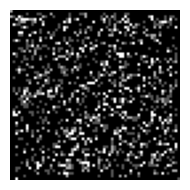

epoch:30/100: training loss 0.00813287 [============================= ]
epoch:40/100: training loss 0.00934006 [============================= ]
epoch:50/100: training loss 0.00675234 [============================= ]
validation loss: 0.005335 loss: 0.0075 [============================= ]


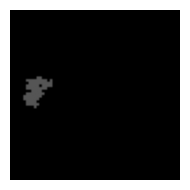

epoch:60/100: training loss 0.00688756 [============================= ]
epoch:70/100: training loss 0.00602437 [============================= ]
epoch:80/100: training loss 0.00399027 [============================= ]
validation loss: 0.003733 loss: 0.0017 [============================= ]


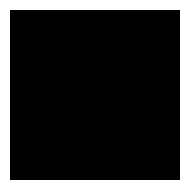

epoch:90/100: training loss 0.00380550 [============================= ]
train completed, total time: 1144.4533338546753.====================== ]


In [ ]:
from monai.utils import progress_bar

lambda_topoloss = 1e-5  # best value found in the TopoDiffNet paper
topo_loss_fn = TI_Loss(dim=2, connectivity=4, inclusion=[[2, 1], [3, 2]], exclusion=[[1, 3]])
to_onehot = transforms.AsDiscrete(to_onehot=4, dim=1)

max_epochs = 100  # 200 was too much
val_interval = 30
epoch_loss_list = []
val_epoch_loss_list = []
print_every = 10
loss = .0

scaler = GradScaler("cuda")
total_start = time.time()

for epoch in range(max_epochs):
    topodiffnet.train()
    epoch_loss = 0
    for step,batch in enumerate(train_loader):

        progress_bar(step, len(train_loader), desc=f"Epoch {epoch+1}/{max_epochs}. Train loss: {loss:.4f}")

        labels_int = batch["label"].to(device)  # integer labels
        one_hot_labels = to_onehot(labels_int)
        images = one_hot_labels.to(device)

        optimizer.zero_grad(set_to_none=True)

        with autocast("cuda", enabled=False):
            noise = torch.randn_like(images).to(device)
            timesteps = torch.randint(
                0, inferer.scheduler.num_train_timesteps, (images.shape[0],), device=images.device
            ).long()

            noise_pred, denoised_image = inferer(
                inputs=images, diffusion_model=topodiffnet, noise=noise, timesteps=timesteps
            )

            # argmax target and denoised image for topology loss
            labels_int = torch.argmax(labels_int, dim=1, keepdim=True) 
            denoised_image = torch.argmax(denoised_image, dim=1, keepdim=True)  
            
            mse_loss = F.mse_loss(noise_pred.float(), noise.float())
            topo_loss = topo_loss_fn(denoised_image.float(), labels_int)
            loss = mse_loss + lambda_topoloss * topo_loss

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        epoch_loss += loss.item()

    if epoch % print_every == 0:
        print(f"epoch:{epoch}/{max_epochs}: training loss {epoch_loss / len(train_loader):.6f}")

    epoch_loss_list.append(epoch_loss / len(train_loader))

    if (epoch + 1) % val_interval == 0:
        topodiffnet.eval()
        val_epoch_loss = 0
        for batch in val_loader:
            labels_int = batch["label"].to(device)
            one_hot_labels = to_onehot(labels_int)
            images = one_hot_labels.to(device)

            with torch.no_grad():
                with autocast("cuda", enabled=False):
                    noise = torch.randn_like(images).to(device)
                    timesteps = torch.randint(
                        0, inferer.scheduler.num_train_timesteps, (images.shape[0],), device=images.device
                    ).long()

                    noise_pred, denoised_image = inferer(
                        inputs=images, diffusion_model=topodiffnet, noise=noise, timesteps=timesteps
                    )
                    # argmax target and denoised image for topology loss
                    labels_int = torch.argmax(labels_int, dim=1, keepdim=True)
                    denoised_image = torch.argmax(denoised_image, dim=1, keepdim=True)

                    val_mse_loss = F.mse_loss(noise_pred.float(), noise.float())
                    val_topo_loss = topo_loss_fn(denoised_image.float(), labels_int)
                    val_loss = val_mse_loss + lambda_topoloss * val_topo_loss

            val_epoch_loss += val_loss.item()
        val_epoch_loss_list.append(val_epoch_loss / len(val_loader))
        print(f"validation loss: {val_epoch_loss_list[-1]:.6f}")

        noise = torch.randn((1, 4, 64, 64)).to(device)
        scheduler.set_timesteps(num_inference_steps=1000)
        with autocast("cuda", enabled=True):
            image = inferer.sample(input_noise=noise, diffusion_model=topodiffnet, scheduler=scheduler, verbose=False)

        image = image.argmax(dim=1, keepdim=True)[0, 0]  # Convert to integer labels for visualization
        plt.figure(figsize=(2, 2))
        plt.imshow(image.cpu(), vmin=0, vmax=3, cmap="gray")
        plt.axis("off")
        plt.tight_layout()
        plt.show() 

total_time = time.time() - total_start
print(f"train completed, total time: {total_time}.")


In [ ]:
# save the model checkpoint

torch.save({
    'model_state_dict': topodiffnet.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
}, '/home/pacificrim/topo-seg/topodiffnet_checkpoint.pth')
print("Saved TopoDiffNet checkpoint")

In [ ]:
# load the model checkpoint

checkpoint = torch.load('/home/pacificrim/topo-seg/topodiffnet_checkpoint.pth')
topodiffnet.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
print("Loaded TopoDiffNet checkpoint")

## ControlNet (inference)

In [ ]:
noise = torch.randn((1, 4, 64, 64)).to(device)  # noise for diff net inference
seg = inferer.sample(input_noise=noise, diffusion_model=topodiffnet, scheduler=scheduler, verbose=False).argmax(dim=1, keepdim=True).float()  # Convert to integer labels for visualization
num_classes = 4 

noise_controlnet = torch.randn((1, 1, 64, 64)).float().to(device)  # noise for controlnet

mri = controlnet_inferer.sample(
    input_noise=noise_controlnet,
    diffusion_model=model,
    controlnet=controlnet,
    cn_cond=seg,
    scheduler=scheduler,
    verbose=True,
)

plt.figure(figsize=(4, 2))

plt.subplot(1, 2, 1)
plt.imshow(seg[0, 0].cpu().numpy(), cmap="gray")
plt.title("Generated label")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(mri[0, 0].cpu().numpy(), cmap="gray")
plt.title("Generated MRI")
plt.axis("off")

plt.tight_layout()
plt.show()

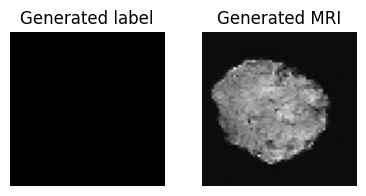

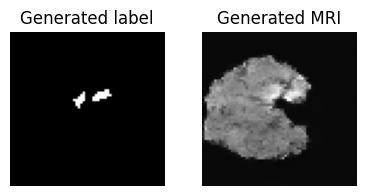

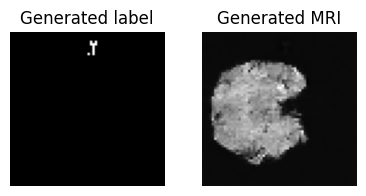

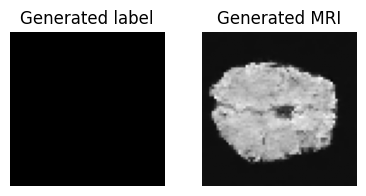

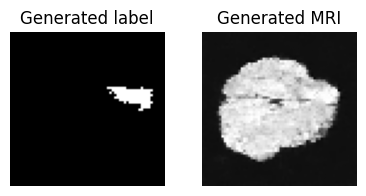

(64, 64, 1)


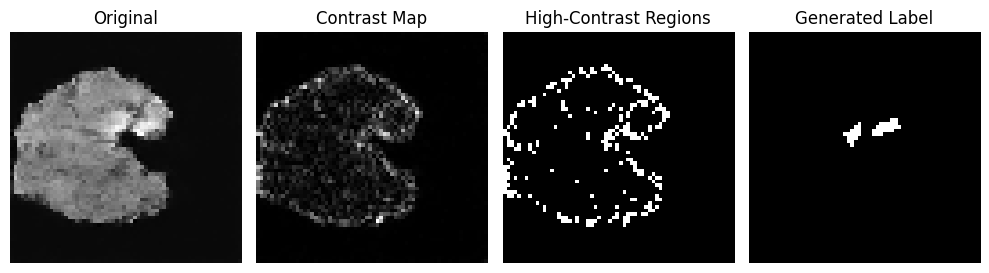

In [69]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load grayscale image
# convert mri to grayscale
img = mri[0].permute(1, 2, 0).cpu().numpy()

print(img.shape)
#normalise to 255
img = cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX)
# convert to uint8
img = np.uint8(img)
img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)


# Compute Laplacian (second derivative) to highlight regions of rapid intensity change
laplacian = cv2.Laplacian(img, cv2.CV_64F)

# Take absolute value and normalize for visualization
contrast_map = np.uint8(255 * np.abs(laplacian) / np.max(np.abs(laplacian)))

# Threshold to show only high-contrast regions
_, high_contrast = cv2.threshold(contrast_map, 60, 255, cv2.THRESH_BINARY)

# Show results
plt.figure(figsize=(10, 4))
plt.subplot(1, 4, 1)
plt.imshow(img, cmap="gray")
plt.title("Original")
plt.axis("off")

plt.subplot(1, 4, 2)
plt.imshow(contrast_map, cmap="hot")
plt.title("Contrast Map")
plt.axis("off")

plt.subplot(1, 4, 3)
plt.imshow(high_contrast, cmap="gray")
plt.title("High-Contrast Regions")
plt.axis("off")

#subplot of seg
plt.subplot(1, 4, 4)
plt.imshow(seg[0, 0].cpu().numpy(), cmap="gray")
plt.title("Generated Label")
plt.axis("off")

plt.tight_layout()
plt.show()
